In [1]:
import os
import glob
import numpy as np
import pandas as pd

import time
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.metrics import log_loss
from sklearn.decomposition import PCA, NMF, FastICA
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# Setting up the possible latent dimensions
# A total of 27 latent dimensions are taken under consideration

k_list = []
k_list.extend(list(range(2, 10)))
k_list.extend(list(range(10, 20, 2)))
k_list.extend(list(range(20, 50, 5)))
k_list.extend(list(range(50, 61, 10)))
k_list.append(78)
k_list.extend(list(range(80, 100, 10)))
k_list.extend(list(range(100, 176, 25)))

print("Latent dimensions:")
print(k_list)

Latent dimensions:
[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40, 45, 50, 60, 78, 80, 90, 100, 125, 150, 175]


In [4]:
# Read the data. The df_new file has additional information about each sample
# such as the following:
#   - PCOS/Control
#   - Cell type
#   - Dataset they belong to

common_norm_df = pd.read_csv('/content/drive/MyDrive/aacb_project/datasets/common_normalized.csv', index_col=0)
df_new = pd.read_csv("/content/drive/MyDrive/aacb_project/datasets/control_pcos_celltype_mapping.csv")
display(df_new)

,sample_id,PCOS/Control,cell_type,dataset
0,GSM1174425,PCOS,endothelial,GDS4987
1,GSM1174429,PCOS,endothelial,GDS4987
2,GSM1174436,PCOS,endothelial,GDS4987
3,GSM1174427,PCOS,epithelial,GDS4987
4,GSM1174430,PCOS,epithelial,GDS4987
...,...,...,...,...
170,GSM27534,control,theca,GDS1050
171,GSM27543,valproic,theca,GDS1050
172,GSM27546,valproic,theca,GDS1050
173,GSM27548,valproic,theca,GDS1050


In [5]:
# Rearrange the rows in df_new to ensure that the 
position = []
values = list(df_new["sample_id"])
for i,j in enumerate(common_norm_df["sample_id"]):
    position.append(values.index(j))

df_new = df_new.loc[position]
df_new = df_new.reset_index()
df_new = df_new.drop("index", axis=1)

# Merge the two dataframes together
result = pd.merge(common_norm_df, df_new[df_new.columns[:-1]], how='inner', on='sample_id')
display(result)

,sample_id,27,36,59,87,94,105,153,159,164,226,288,290,311,330,334,335,345,355,359,377,382,389,392,394,405,408,420,430,443,463,476,487,488,515,533,552,567,572,582,...,92822,93164,93487,93974,6248_84301,8693_100528030,100506581,112399,112479,374655,375035,375057,113251,114088,114791,114882,116228,116285,116985,116986,51463_653519,118491,118987,120227,645644,100129482,100529257_55333,253512,122704,253959,254359,254531,100132341,387893,388336,259266,261726,PCOS,PCOS/Control,cell_type
0,GSM27536,0.693258,0.125461,0.336077,0.044463,0.267819,0.467742,0.490196,0.008907,0.370576,0.953515,0.000000,0.060236,0.230814,0.078014,0.119300,1.000000,1.000000,0.000000,0.712054,0.648867,0.535433,0.593551,0.651320,0.000000,0.000000,1.000000,0.132791,1.000000,0.000000,0.263318,0.725872,0.701149,0.395953,0.302829,0.839330,0.349876,0.835372,0.502399,0.800414,...,0.146067,0.064516,0.915703,0.768041,0.925659,0.000000,0.855740,0.130112,0.000000,1.000000,0.086751,0.288095,0.000000,0.560748,0.965517,0.000000,0.121212,0.000000,1.000000,0.261745,0.209231,0.061603,0.295745,0.489703,0.481948,0.113924,0.100254,0.000000,0.369072,0.000000,0.396190,1.000000,0.412466,0.000000,0.312354,0.198387,0.120213,1,PCOS,theca
1,GSM27537,0.214607,0.487085,0.589704,0.104294,0.000000,0.106452,0.000000,0.631829,0.476058,1.000000,0.040900,0.038093,0.799387,0.131206,0.118719,0.000000,0.025316,0.216724,0.023437,0.286346,0.619005,0.946925,0.854954,0.337931,0.352278,0.149398,0.636856,0.000000,0.184211,0.238965,0.808785,0.609195,0.561854,0.916302,0.265155,0.285360,0.808202,0.291843,0.515512,...,0.070225,0.129032,0.512184,0.694845,0.000000,0.536028,0.937385,0.000000,0.809129,0.158155,0.586751,0.424603,0.644419,1.000000,0.000000,0.949077,0.994318,0.085938,0.427987,0.049664,0.763077,0.000000,1.000000,0.080092,0.000000,0.082278,0.407360,0.418699,0.437113,0.367855,0.564190,0.497418,0.325390,0.356499,0.173660,0.430645,1.000000,1,PCOS,theca
2,GSM27538,0.241573,0.446494,0.548203,0.247916,0.033477,1.000000,0.137255,0.457245,0.529493,0.864979,0.321063,0.212610,0.564342,0.124113,0.000000,0.119891,0.000000,0.205272,0.253348,0.610282,1.000000,0.764284,0.762722,0.244444,0.062224,0.227353,0.002710,0.000000,0.338057,0.135464,1.000000,0.452107,0.908008,0.264473,1.000000,0.250620,0.634656,0.218459,0.446225,...,0.390449,0.322581,1.000000,0.691409,0.534772,0.061511,0.709024,0.009294,0.578838,0.166392,0.323344,0.000000,0.183544,0.887850,0.754310,0.677912,0.556818,0.035156,0.000000,0.618792,0.622154,0.575527,0.753191,0.338673,0.245172,0.000000,0.480964,0.317073,0.618557,0.229993,0.712381,0.686747,0.252062,0.371943,0.097902,0.517742,0.673404,1,PCOS,theca
3,GSM27540,0.000000,0.173432,0.000000,0.139978,0.242981,0.000000,0.117647,0.350356,0.761277,0.958612,0.243354,1.000000,0.103006,1.000000,0.585332,0.035422,0.778481,0.864088,0.006696,0.321946,0.977631,0.541706,0.052429,0.422222,0.176384,0.000000,0.439024,0.250000,0.350202,0.324201,0.706619,0.689655,0.372847,0.309933,0.948579,0.000000,1.000000,0.230596,0.000000,...,0.839888,0.612903,0.623574,1.000000,0.633094,0.084359,0.448128,0.589219,0.929461,0.337727,0.160883,0.315079,0.539701,0.000000,0.625000,0.810312,0.000000,1.000000,0.135025,0.000000,0.688000,0.151899,0.555319,0.000000,0.359362,0.120253,0.083756,0.158537,0.000000,0.240081,0.354286,0.778830,0.195234,0.444015,0.132867,0.156452,0.730851,1,PCOS,theca
4,GSM27541,0.723596,0.845018,0.373149,0.446988,0.768898,0.212903,0.352941,1.000000,0.722415,0.571534,0.262440,0.150497,0.178874,0.836879,1.000000,0.169619,0.525316,1.000000,0.444196,0.000000,0.000000,0.461032,0.000000,1.000000,0.516903,0.341622,0.116531,0.125000,0.504049,1.000000,0.265945,0.214559,0.254592,1.000000,0.000000,0.665012,0.440670,0.187412,0.415202,...,1.000000,0.000000,0.273651,0.334021,0.654676,0.557118,0.000000,0.124535,1.000000,0.322900,0.000000,0.246825,1.000000,0.186916,0.362069,0.969764,0.507576,0.136719,0.115385,0.053691,0.950154,0.858228,0.821277,0.819222,0.680101,0.120253,0.621827,0.209350,0.171134,1.000000,0.108190,0.254733,0.000000,0.54

In [6]:
def get_cost_reconstruction(X, model, k_list=k_list):
    bce_loss = []
    l2_error = []
    output = {}
    
    print("Calculating Reconstruction Error for:", model.upper())
    time.sleep(1)
    
    if model == "pca":
        for k in tqdm(k_list):
            model = PCA(n_components=k, random_state=4)
            model.fit(X)
            reduced = model.transform(X)
            reconstructed = model.inverse_transform(reduced)
            bce_loss.append(log_loss(X.reshape(-1,).astype(int), reconstructed.reshape(-1,)))
            l2_error.append(np.linalg.norm(X-reconstructed))
            output[k] = reconstructed

    if model == "ica":
        for k in tqdm(k_list):
            model = FastICA(n_components=k, random_state=4, max_iter=400)
            model.fit(X)
            reduced = model.transform(X)
            reconstructed = model.inverse_transform(reduced)
            bce_loss.append(log_loss(X.reshape(-1,).astype(int), reconstructed.reshape(-1,)))
            l2_error.append(np.linalg.norm(X-reconstructed))
            output[k] = reconstructed

    if model == "nmf":
        for k in tqdm(k_list):
            model = NMF(n_components=k, random_state=4, max_iter=400)
            model.fit(X)
            reduced = model.transform(X)
            reconstructed = model.inverse_transform(reduced)
            bce_loss.append(log_loss(X.reshape(-1,).astype(int), reconstructed.reshape(-1,)))
            l2_error.append(np.linalg.norm(X-reconstructed))
            output[k] = reconstructed
    
    return bce_loss, l2_error, output

In [7]:
model_list = ["pca", "ica", "nmf"]
bce_loss = []
l2_error = []
reconstruction_list = {}

X = common_norm_df[common_norm_df.columns[1:-1]].to_numpy()

for model in model_list:
    bce, l2, output = get_cost_reconstruction(X, model)
    bce_loss.append(bce)
    l2_error.append(l2)
    reconstruction_list[model] = output

Calculating Reconstruction Error for: PCA


100%|██████████| 28/28 [00:04<00:00,  6.24it/s]


Calculating Reconstruction Error for: ICA


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Calculating Reconstruction Error for: NMF


100%|██████████| 28/28 [03:17<00:00,  7.04s/it]


In [8]:
z_dict = {}
for k in k_list:
  z_dict[k] = {}
  for algo in model_list:
    z_dict[k][algo] = reconstruction_list[algo][k]

In [9]:
num_cca_trials = 5
epsilon = 1e-6
threshold = 1e-6

def positivedef_matrix_sqrt(array):
  w, v = np.linalg.eigh(array)
  wsqrt = np.sqrt(w)
  sqrtarray = np.dot(v, np.dot(np.diag(wsqrt), np.conj(v).T))
  return sqrtarray

def remove_small(sigma_xx, sigma_xy, sigma_yx, sigma_yy, threshold=1e-6):
  x_diag = np.abs(np.diagonal(sigma_xx))
  y_diag = np.abs(np.diagonal(sigma_yy))
  x_idxs = (x_diag >= threshold)
  y_idxs = (y_diag >= threshold)

  sigma_xx_crop = sigma_xx[x_idxs][:, x_idxs]
  sigma_xy_crop = sigma_xy[x_idxs][:, y_idxs]
  sigma_yx_crop = sigma_yx[y_idxs][:, x_idxs]
  sigma_yy_crop = sigma_yy[y_idxs][:, y_idxs]

  return (sigma_xx_crop, sigma_xy_crop, sigma_yx_crop, sigma_yy_crop, x_idxs, y_idxs)


def compute_ccas(sigma_xx, sigma_xy, sigma_yx, sigma_yy, verbose=True):
  (sigma_xx, sigma_xy, sigma_yx, sigma_yy, x_idxs, y_idxs) = remove_small(sigma_xx, sigma_xy, sigma_yx, sigma_yy)

  numx = sigma_xx.shape[0]
  numy = sigma_yy.shape[0]

  if numx == 0 or numy == 0:
    return ([0, 0, 0], [0, 0, 0], np.zeros_like(sigma_xx),
            np.zeros_like(sigma_yy), x_idxs, y_idxs)

  if verbose:
    print("adding eps to diagonal and taking inverse")
  sigma_xx +=epsilon * np.eye(numx)
  sigma_yy +=epsilon * np.eye(numy)
  inv_xx = np.linalg.pinv(sigma_xx)
  inv_yy = np.linalg.pinv(sigma_yy)

  if verbose:
    print("taking square root")
  invsqrt_xx = positivedef_matrix_sqrt(inv_xx)
  invsqrt_yy = positivedef_matrix_sqrt(inv_yy)

  if verbose:
    print("dot products...")
  arr_x = np.dot(sigma_yx, invsqrt_xx)
  arr_x = np.dot(inv_yy, arr_x)
  arr_x = np.dot(invsqrt_xx, np.dot(sigma_xy, arr_x))
  arr_y = np.dot(sigma_xy, invsqrt_yy)
  arr_y = np.dot(inv_xx, arr_y)
  arr_y = np.dot(invsqrt_yy, np.dot(sigma_yx, arr_y))

  if verbose:
    print("trying to take final svd")
  arr_x_stable = arr_x + epsilon * np.eye(arr_x.shape[0])
  arr_y_stable = arr_y + epsilon * np.eye(arr_y.shape[0])
  try:
      ux, sx, vx = np.linalg.svd(arr_x_stable)
      uy, sy, vy = np.linalg.svd(arr_y_stable)
  except:
      return [0, 0, 0], [0, 0, 0], 0, 0, 0, 0
  sx = np.sqrt(np.abs(sx))
  sy = np.sqrt(np.abs(sy))
  if verbose:
    print("computed everything!")

  return [ux, sx, vx], [uy, sy, vy], invsqrt_xx, invsqrt_yy, x_idxs, y_idxs


def sum_threshold(array, threshold):
  assert (threshold >= 0) and (threshold <= 1), "print incorrect threshold"

  for i in range(len(array)):
    if np.sum(array[:i]) / np.sum(array) >= threshold:
      return i


def create_zero_dict(compute_dirns, dimension):
  return_dict = {}
  return_dict["mean"] = (np.asarray(0), np.asarray(0))
  return_dict["sum"] = (np.asarray(0), np.asarray(0))
  return_dict["cca_coef1"] = np.asarray(0)
  return_dict["cca_coef2"] = np.asarray(0)
  return_dict["idx1"] = 0
  return_dict["idx2"] = 0

  if compute_dirns:
    return_dict["cca_dirns1"] = np.zeros((1, dimension))
    return_dict["cca_dirns2"] = np.zeros((1, dimension))

  return return_dict


def get_cca_similarity(acts1, acts2, threshold=0.98, compute_dirns=True, verbose=True):
  # assert dimensionality equal
  assert acts1.shape[1] == acts2.shape[1], "dimensions don't match"
  # check that acts1, acts2 are transposition
  assert acts1.shape[0] < acts1.shape[1], ("input must be number of neurons by datapoints")
  return_dict = {}

  # compute covariance with numpy function for extra stability
  numx = acts1.shape[0]

  covariance = np.cov(acts1, acts2)
  sigmaxx = covariance[:numx, :numx]
  sigmaxy = covariance[:numx, numx:]
  sigmayx = covariance[numx:, :numx]
  sigmayy = covariance[numx:, numx:]

  # rescale covariance to make cca computation more stable
  xmax = np.max(np.abs(sigmaxx))
  ymax = np.max(np.abs(sigmayy))
  sigmaxx /= xmax
  sigmayy /= ymax
  sigmaxy /= np.sqrt(xmax * ymax)
  sigmayx /= np.sqrt(xmax * ymax)

  ([_, sx, vx], [_, sy, vy], invsqrt_xx, invsqrt_yy, x_idxs,
   y_idxs) = compute_ccas(sigmaxx, sigmaxy, sigmayx, sigmayy,
                          verbose)

  # if x_idxs or y_idxs is all false, return_dict has zero entries
  if (not np.any(x_idxs)) or (not np.any(y_idxs)):
    return create_zero_dict(compute_dirns, acts1.shape[1])

  if compute_dirns:
    # orthonormal directions that are CCA directions
    cca_dirns1 = np.dot(vx, np.dot(invsqrt_xx, acts1[x_idxs]))
    cca_dirns2 = np.dot(vy, np.dot(invsqrt_yy, acts2[y_idxs]))

  # get rid of trailing zeros in the cca coefficients
  idx1 = sum_threshold(sx, threshold)
  idx2 = sum_threshold(sy, threshold)

  return_dict["neuron_coeffs1"] = np.dot(vx, invsqrt_xx)
  return_dict["neuron_coeffs2"] = np.dot(vy, invsqrt_yy)
  return_dict["cca_coef1"] = sx
  return_dict["cca_coef2"] = sy
  return_dict["x_idxs"] = x_idxs
  return_dict["y_idxs"] = y_idxs
  # summary statistics
  return_dict["mean"] = (np.mean(sx[:idx1]), np.mean(sy[:idx2]))
  return_dict["sum"] = (np.sum(sx), np.sum(sy))

  if compute_dirns:
    return_dict["cca_dirns1"] = cca_dirns1
    return_dict["cca_dirns2"] = cca_dirns2

  return return_dict


def robust_cca_similarity(acts1, acts2, threshold=0.98, compute_dirns=True, verbose=False):
  for trial in range(num_cca_trials):
    try:
      return_dict = get_cca_similarity(acts1, acts2, threshold, compute_dirns, verbose=verbose)
    except np.LinAlgError:
      acts1 = acts1 * 1e-1 + np.random.normal(size=acts1.shape) * epsilon
      acts2 = acts2 * 1e-1 + np.random.normal(size=acts1.shape) * epsilon
      if trial + 1 == num_cca_trials:
        raise

  return return_dict

In [10]:
def get_svcca_across_algorithm_stability(z_dict, algorithms, threshold=0.98):
    output_list = []
    for i in range(0, len(algorithms)):
        algorithm_a = algorithms[i]
        for j in range(0, len(algorithms)):
            algorithm_b = algorithms[j]
            compile_list = [algorithm_a, algorithm_b]
            result = robust_cca_similarity(z_dict[algorithm_a], z_dict[algorithm_b], verbose=False, threshold=threshold)
            compile_list += [np.mean(result["mean"])]
            output_list.append(compile_list)

    # Convert output to pandas dataframe
    out_cols = [
        "algorithm_1",
        "algorithm_2",
        "svcca_mean_similarity",
    ]
    return pd.DataFrame(output_list, columns=out_cols)

In [11]:
large_svcca_results_list = []
for z in k_list:
    print("Calculating... for dimension {}".format(z))
    # Perform across algorithm SVCCA
    svcca_out_df = (get_svcca_across_algorithm_stability(z_dict=z_dict[z], algorithms=model_list))
    
    # Append info to the output dataframe
    svcca_out_df = svcca_out_df.assign(z_dim=z)

    large_svcca_results_list.append(svcca_out_df)

Calculating... for dimension 2
Calculating... for dimension 3
Calculating... for dimension 4
Calculating... for dimension 5
Calculating... for dimension 6
Calculating... for dimension 7
Calculating... for dimension 8
Calculating... for dimension 9
Calculating... for dimension 10
Calculating... for dimension 12
Calculating... for dimension 14
Calculating... for dimension 16
Calculating... for dimension 18
Calculating... for dimension 20
Calculating... for dimension 25
Calculating... for dimension 30
Calculating... for dimension 35
Calculating... for dimension 40
Calculating... for dimension 45
Calculating... for dimension 50
Calculating... for dimension 60
Calculating... for dimension 78
Calculating... for dimension 80
Calculating... for dimension 90
Calculating... for dimension 100
Calculating... for dimension 125
Calculating... for dimension 150
Calculating... for dimension 175


In [12]:
svcca_results_df = pd.concat(large_svcca_results_list).reset_index(drop=True)
svcca_results_df.columns = ['algorithm_1', 'algorithm_2', 'svcca_mean_similarity', 'z_dim']
svcca_results_df.head(10)

,algorithm_1,algorithm_2,svcca_mean_similarity,z_dim
0,pca,pca,0.027749,2
1,pca,ica,0.027750,2
2,pca,nmf,0.016104,2
3,ica,pca,0.027750,2
4,ica,ica,0.027750,2
5,ica,nmf,0.016106,2
6,nmf,pca,0.016104,2
7,nmf,ica,0.016106,2
8,nmf,nmf,0.016130,2
9,pca,pca,0.044437,3


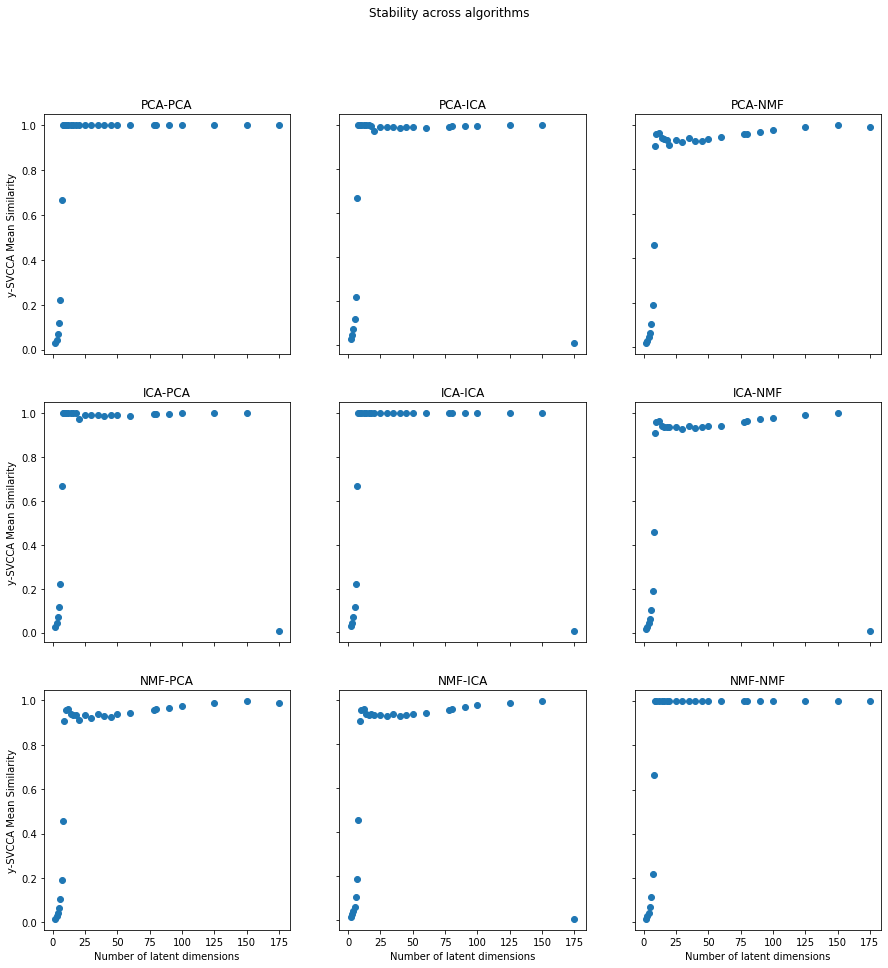

In [19]:
num_models = len(model_list)

fig, axs = plt.subplots(num_models, num_models, figsize=(15,15))
x = k_list[:]

for i in range(num_models):
  alg1 = model_list[i]
  for j in range(num_models):
    alg2 = model_list[j]
    y = svcca_results_df[svcca_results_df["algorithm_1"] == alg1]
    y = y[y["algorithm_2"] == alg2]["svcca_mean_similarity"].values
    axs[i, j].scatter(x, y)
    axs[i, j].set_title('{}-{}'.format(alg1.upper(), alg2.upper()))

for ax in axs.flat:
    ax.set(xlabel='Number of latent dimensions', ylabel='y-SVCCA Mean Similarity')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.suptitle('Stability across algorithms')
plt.savefig('/content/drive/MyDrive/aacb_project/images/stability_across_algorithms.png')